In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
import time
import rk_solver_cpp
from scipy.integrate import solve_ivp
from tqdm import tqdm

In [4]:
def setup_gas(T, pp):
    gas = ct.Solution('/Users/elotech/Documents/CODES/rk_solvers/RL/ppo/mechanism_files/ch4_53species.yaml')
    gas.TP = T, ct.one_atm*pp
    gas.set_equivalence_ratio(1.0, 'CH4', 'O2:1.0, N2:3.76')
    return gas, pp 

def combustion_ode(gas, pp):
    def f(t, Y):
        T = Y[0]
        YY = Y[1:]
        gas.TPY = T, ct.one_atm*pp, YY
        species_rates = gas.net_production_rates*gas.molecular_weights/gas.density
        species_h = gas.partial_molar_enthalpies/gas.molecular_weights
        temp_rate = -np.sum(species_rates*species_h/gas.cp_mass)
        return np.concatenate((np.array([temp_rate]), species_rates), axis=0)
    return f

def detect_ignition(Temperatures, tolerance=1e-3):
    return np.any(np.diff(Temperatures) > tolerance)




In [5]:
T_initial = 1400
pp_initial = 40
gas, pp = setup_gas(T_initial, pp_initial)
t_end = 2e-4
dt = 1e-6

npoints = int(t_end/dt)

t_span = np.linspace(0, t_end, npoints + 1)

f = combustion_ode(gas, pp)
y0 = np.hstack([[gas.T], gas.Y])


In [6]:
rk23 = rk_solver_cpp.RK23(f, t_span[0], y0, t_span[-1], rtol=1e-6, atol=1e-8)


In [5]:
message = rk23.step()

In [8]:
sol = rk23.compute_dense_output()

In [ ]:
sol.call(t_span[0])

In [ ]:
rk23.get_y()


In [4]:
def solve_with_cpp(f, t_span, y0, rtol=1e-6, atol=1e-8):
    rk23 = rk_solver_cpp.RK23(f, t_span[0], y0, t_span[-1], rtol=rtol, atol=atol)
    print(f"Solving with C++ RK23")
    start_time = time.time()
    try:
        
        result_cpp = rk_solver_cpp.solve_ivp(rk23, t_span)
        time_cpp = time.time() - start_time
        cpp_success = result_cpp['success']
        if cpp_success:
            ys_cpp = result_cpp['y']
        else:
            print(f"C++ RK23 failed: {result_cpp['message']}")
        return ys_cpp, time_cpp, cpp_success
    except Exception as e:
        print(f"C++ RK23 failed: {str(e)}")
        time_cpp = None
        cpp_success = False
        return None, None, cpp_success

In [ ]:

ys_cpp, time_cpp, cpp_success = solve_with_cpp(f, t_span, y0)



In [12]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import cantera as ct
from scipy.integrate import solve_ivp
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rk_solver_cpp


def run_cantera_solver(
    mech_file,
    initial_state,
    end_time,
    tcfd,
    species_to_track,
    rtol=1e-10,
    atol=1e-20
):
    # Set up the reactor
    gas = ct.Solution(mech_file)
    gas.TPX = initial_state['T'], initial_state['P'], initial_state['X']
    
    reactor = ct.IdealGasConstPressureReactor(gas)
    sim = ct.ReactorNet([reactor])
    sim.rtol = rtol
    sim.atol = atol

    # Pre-allocate arrays for results
    num_steps = int(end_time / tcfd) + 1
    times = np.zeros(num_steps)
    temperatures = np.zeros(num_steps)
    pressures = np.zeros(num_steps)
    species_profiles = {spec: np.zeros(num_steps) for spec in species_to_track}
    
    t = 0.0
    for i in range(num_steps):
        sim.advance(t)
        times[i] = t
        temperatures[i] = reactor.T
        pressures[i] = reactor.thermo.P
        for spec in species_to_track:
            species_profiles[spec][i] = reactor.thermo[spec].Y  # Use mass fractions
        t += tcfd
    
    results = {
        'times': times,
        'temperatures': temperatures,
        'pressures': pressures,
        'species_profiles': species_profiles,
    }
    return results

class CombustionEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, mech_file, initial_state, end_time, tcfd, species_to_track, Etol=1e-7, state_change_threshold=1e-4, 
                 add_net_production_rates=False, include_dt_etol=False, alpha=0.8, beta=0.2, beta_=0.1, epsilon=1e-10, 
                 integrator_list=['Radau', 'BDF'], tolerance_list=[(1e-14, 1e-15), (1e-8, 1e-8)], time_threshold=0.01):
        super(CombustionEnv, self).__init__()
        
        self.mech_file = mech_file
        self.initial_state = initial_state
        self.end_time = end_time
        self.tcfd = tcfd
        self.species_to_track = species_to_track
        self.Etol = Etol  # User-specified error tolerance
    
        self.current_step = 0
        
        self.alpha = alpha
        self.beta = beta
        self.beta_ = beta_
        self.epsilon = epsilon
        self.integrator_list = integrator_list
        self.tolerance_list = tolerance_list
        self.time_threshold = time_threshold
        # Load gas object
        self.gas = ct.Solution(self.mech_file)
        self.gas.TPX = self.initial_state['T'], self.initial_state['P'], self.initial_state['X']
        self.P0 = self.initial_state['P']
        self.num_species = self.gas.n_species
        self.species_names = self.gas.species_names
        self.state_change_threshold = state_change_threshold  # New parameter
        self.add_net_production_rates = add_net_production_rates
        self.include_dt_etol = include_dt_etol
        # Define action and observation spaces
        self._define_action_space()
        self._define_observation_space()
        
        # Reference solution (can be precomputed)
        self.reference_solution = self._compute_reference_solution()
        
        self.reset()
    
    def _define_action_space(self):
        # Define possible integrators and tolerances
        self.integrators = self.integrator_list
        self.tolerances = self.tolerance_list
        
        # Create a list of all possible (integrator, tolerance) combinations
        self.action_list = []
        for integrator in self.integrators:
            for rtol, atol in self.tolerances:
                self.action_list.append((integrator, rtol, atol))
        
        self.action_space = spaces.Discrete(len(self.action_list))
    
    def _define_observation_space(self):
        # Number of species to track
        self.num_tracked_species = len(self.species_to_track)
        if self.add_net_production_rates:
            self.num_tracked_species += self.num_tracked_species
        if self.include_dt_etol:
            self.num_tracked_species += 2
        # Observation space: [Y1, Y2, ..., Yn, T, dt, Etol]
        low = np.zeros(self.num_tracked_species + 1) # +1 for temperature
        high = np.ones(self.num_tracked_species + 1) * 10 # +1 for temperature
        
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
    
    def reset(self):
        self.current_step = 0
        self.t = 0.0
        self.gas.TPX = self.initial_state['T'], self.P0, self.initial_state['X']
        self.y = np.hstack([self.gas.T, self.gas.Y])
        self.cummulative_cpu_time = 0
        self.cummulative_reward = 0
        self.num_steps = int(self.end_time / self.tcfd)
        
        # Initialize storage for the simulation results
        self.temperatures = []
        self.species_profiles = {spec: [] for spec in self.species_to_track}
        self.cpu_times = []
        self.errors = []
        self.action_history = []
        self.previous_action = None
        self.action_distribution = np.zeros(len(self.action_list))
        self.rewards = []
        self.time_rewards = []
        self.error_rewards = []
        self.state_changes = []
        self.state_change_values = []
        return self._get_observation()
    
    def set_Etol_and_tcfd(self, Etol, tcfd):
        if Etol != self.Etol or tcfd != self.tcfd:
            self.Etol = Etol
            self.tcfd = tcfd
            _ = self.reset()
            self.reference_solution = self._compute_reference_solution()
        else:
            print(f"Etol and tcfd are the same as the previous values: {self.Etol}, {self.tcfd}")
        
        
    def step(self, action):
        # Get integrator and tolerances from action
        integrator, rtol, atol = self.action_list[action]
        
        # Define the ODE function for both scipy and custom solvers
        def dydt(t, y):
            T = y[0]
            Y = y[1:]
            self.gas.TPY = T, self.P0, Y
            rho = self.gas.density_mass
            wdot = self.gas.net_production_rates
            cp = self.gas.cp_mass
            h = self.gas.partial_molar_enthalpies
            
            dTdt = -(np.dot(h, wdot) / (rho * cp))
            dYdt = wdot * self.gas.molecular_weights / rho
            
            return np.hstack([dTdt, dYdt])

        try:
            start_time = time.time()
            
            if integrator.startswith('CPP_'):
                # Use custom C++ solver
                solver_class = rk_solver_cpp.RK23 if integrator == 'CPP_RK23' else rk_solver_cpp.RK45
                solver = solver_class(dydt, float(self.t), np.array(self.y), float(self.t + self.tcfd), 
                                   rtol=rtol, atol=atol)
                
                # Use our solve_ivp implementation
                result = rk_solver_cpp.solve_ivp(solver,  np.array(float(self.t + self.tcfd)))
                
                if result['success']:
                    sol_y = result['y'][-1]  # Get the last state
                    success = True
                else:
                    raise RuntimeError(result['message'])
                
            else:
                # Use scipy solver
                sol = solve_ivp(
                    dydt,
                    (self.t, self.t + self.tcfd),
                    self.y,
                    method=integrator,
                    t_eval=[self.t + self.tcfd],
                    rtol=rtol,
                    atol=atol
                )
                sol_y = sol.y[:, -1]
                success = sol.success
            
            cpu_time = time.time() - start_time
            
            if not success:
                raise RuntimeError("Integration failed")
            
            # Store previous state and update current state
            previous_state = self.y.copy()
            self.y = sol_y
            self.t += self.tcfd
            self.current_step += 1
            state_changed, state_change_value = self._state_changed_significantly(previous_state, self.y)
            self.state_changes.append(state_changed)
            self.state_change_values.append(state_change_value)
             # Extract current temperature and species mass fractions
            T_current = self.y[0]
            Y_current = self.y[1:]
            
            # Compute error compared to reference solution
            ref_T = self.reference_solution['temperatures'][self.current_step]
            ref_T_normalized, T_current_normalized = ref_T / self.initial_state['T'], T_current / self.initial_state['T']
            error = np.abs(T_current_normalized - ref_T_normalized)
            self.errors.append(error)
            
            # Compute reward
            reward, time_reward, error_reward = self._compute_reward(cpu_time=cpu_time, error=error)
            self.time_rewards.append(time_reward)
            self.error_rewards.append(error_reward)
            self.cummulative_cpu_time += cpu_time
            self.cummulative_reward += reward
            self.rewards.append(reward)
            self.cpu_times.append(cpu_time)
            # Check if the episode is done
            done = self.current_step >= self.num_steps
            
            # Update stored results
            self.temperatures.append(T_current)
            for spec in self.species_to_track:
                idx = self.gas.species_index(spec)
                self.species_profiles[spec].append(Y_current[idx])
        
            observation = self._get_observation()
            temperature_error, species_error = self.calculate_error()
            info = {'cpu_time': cpu_time, 'error': error, 'state_changed': self.state_changes, 'state_change_value': self.state_change_values, 'cummulative_cpu_time': self.cummulative_cpu_time, 'cummulative_reward': self.cummulative_reward, 'temperature_error': temperature_error, 'species_error': species_error, 'action_history': self.action_history, 'action_distribution': self.action_distribution, 'time_reward': time_reward, 'error_reward': error_reward}
            self.previous_action = action
            
            if done:
                if self.cummulative_cpu_time/self.num_steps > 0.05:
                    reward -= (self.cummulative_cpu_time/self.num_steps - 0.05) * 100
            
            return observation, reward, done, False, info
        except Exception as e:
            print(f"Error in step: {e}")
            import traceback
            traceback.print_exc()
            return self._get_observation(), -300.0, True, False, {'error': 10000, 'cpu_time': cpu_time, 'state_changed': False, 'state_change_value': 0.0, 'time_reward': 0.00001, 'error_reward': 0.00001, 'previous_state': previous_state, 'current_state': self.y}

    def _state_changed_significantly(self, previous_state, current_state):
        if type(previous_state) == list:
            previous_state = np.array(previous_state)
        if type(current_state) == list:
            current_state = np.array(current_state)
        # Compute the L2 norm of the change in state
        state_change = np.linalg.norm(current_state - previous_state)
        
        # Check if the change is above the threshold
        return state_change > self.state_change_threshold, state_change
    
    def calculate_error(self):
        # Compute the error between the current state and the reference solution up to the current step
        ref_T = self.reference_solution['temperatures'][self.current_step-1]
        actual_T = self.temperatures[self.current_step-1]
        temperature_error = np.abs(actual_T - ref_T)

        ref_species_profiles = self.reference_solution['species_profiles']
        actual_species_profiles = self.species_profiles
        species_error = {}
        for spec in self.species_to_track:
            idx = self.gas.species_index(spec)
            ref_Y = ref_species_profiles[spec][self.current_step-1]
            actual_Y = actual_species_profiles[spec][self.current_step-1]
            species_error[spec] = np.abs(actual_Y - ref_Y)
    
        return temperature_error, species_error
    
    def _compute_reward(self, cpu_time, error):
        epsilon = 1e-10  # Small constant to avoid division by zero
        etol = self.Etol  # Error tolerance
        time_threshold = self.time_threshold
        
        # Weight parameters
        w_time = self.alpha
        w_error = self.beta

        # Compute time component of the reward
        time_reward = 1 / (1 + cpu_time / time_threshold)

        # Compute error ratio
        error_ratio = error / (etol + epsilon)

        # Compute error component of the reward
        if error <= etol:
            error_reward = 1 - (error_ratio / 2)  # Reward for being under the threshold
        else:
            error_reward = max(0, 1 - error_ratio)  # Penalize for being over the threshold

        reward = (w_time * time_reward + w_error * error_reward)
        return reward, time_reward, error_reward
    
    def _get_observation(self):
        # Get current temperature and species mass fractions
        T = self.y[0]
        Y = self.y[1:]
        
        # Extract mass fractions of tracked species
        Y_tracked = np.array([Y[self.gas.species_index(spec)] for spec in self.species_to_track])
        if self.add_net_production_rates:
            # include the net production rates of the tracked species
            net_production_rates = np.array([self.gas.net_production_rates[self.gas.species_index(spec)] for spec in self.species_to_track])
            Y_tracked = np.hstack([Y_tracked, net_production_rates])
        
        # Clip species mass fractions to 10^-20
        Y_tracked = np.clip(Y_tracked, 1e-20, None)
        
        # Compute the logarithm of the species mass fractions
        Y_log = np.log(Y_tracked)
        
        # Normalize the observation
        Y_normalized = (Y_log - np.mean(Y_log)) / np.std(Y_log)
        T_normalized = T / self.initial_state['T']
        
        if self.include_dt_etol:
            # Compute the logarithm of the CFD timestep
            dt_log = np.log(self.tcfd)
            Etol_log = np.log(self.Etol)
        
            observation = np.hstack([Y_normalized, T_normalized, dt_log, Etol_log]).astype(np.float32)
        else:
            observation = np.hstack([Y_normalized, T_normalized]).astype(np.float32)
        
        #print(f"Observation: {observation}")
        return observation
    
    def _compute_reference_solution(self):
        # Compute or load the reference solution with tight tolerances
        print("Computing reference solution...")
        reference_results = run_cantera_solver(
            self.mech_file,
            self.initial_state,
            self.end_time,
            self.tcfd,
            self.species_to_track,
            rtol=1e-10,
            atol=1e-20
        )
        return reference_results
    
    def compare_state_with_reference(self, save_path=None):
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 30))

        # Plot temperature comparison
        reference_temperatures = self.reference_solution['temperatures'][:self.current_step]
        actual_temperatures = self.temperatures
        ax1.plot(reference_temperatures, label='Reference Temperature')
        ax1.plot(actual_temperatures, label='Actual Temperature')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Temperature (K)')
        ax1.legend()
        ax1.set_title('Temperature Comparison')

        # Plot species profiles comparison
        reference_species_profiles = self.reference_solution['species_profiles']
        actual_species_profiles = self.species_profiles
        for spec in self.species_to_track:
            ax2.plot(reference_species_profiles[spec][:self.current_step], label=f'Reference {spec}')
            ax2.plot(actual_species_profiles[spec][:self.current_step], label=f'Actual {spec}')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Species Mass Fractions')
        ax2.legend()
        ax2.set_title('Species Profiles Comparison')

        # Plot action history
        ax3.plot(self.action_history)
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Action')
        ax3.set_title('Action History')

        # Plot state changes
        ax4.plot(self.state_changes)
        ax4.set_xlabel('Time')
        ax4.set_ylabel('State Change')
        ax4.set_title('State Changes')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()

        plt.close()
    
    def __copy__(self):
        new_env = CombustionEnv(
            mech_file=self.mech_file,
            initial_state=self.initial_state,
            end_time=self.end_time,
            tcfd=self.tcfd,
            species_to_track=self.species_to_track,
            Etol=self.Etol,
            state_change_threshold=self.state_change_threshold,
            add_net_production_rates=self.add_net_production_rates,
            include_dt_etol=self.include_dt_etol,
            alpha=self.alpha,
            beta=self.beta,
            beta_=self.beta_,
            epsilon=self.epsilon,
            integrator_list=self.integrator_list,
            tolerance_list=self.tolerance_list
        )
        new_env.reference_solution = self.reference_solution
        new_env.temperatures = self.temperatures
        new_env.species_profiles = self.species_profiles
        new_env.cpu_times = self.cpu_times
        new_env.errors = self.errors
        new_env.action_history = self.action_history
        new_env.action_distribution = self.action_distribution
        new_env.current_step = self.current_step
        
        return new_env

    def compare_with_fixed_action(self, save_path=None):
        """ Copy the current environment four times and run each with each action and also run the reference solution"""
        action_list = np.arange(len(self.action_list))
        env_list = [self.__copy__() for _ in range(len(action_list))]
        all_cpu_times = [[] for _ in range(len(action_list))]
        all_errors = [[] for _ in range(len(action_list))]
        all_rewards = [[] for _ in range(len(action_list))]
        time_rewards = [[] for _ in range(len(action_list))]
        error_rewards = [[] for _ in range(len(action_list))]
        # reset the environments
        try:
            for env in env_list:
                env.reset()
            while True:
                all_action_rewards = []
                for (i, env) in enumerate(env_list):
                    action = action_list[i]
                    next_state, reward, terminated, truncated, info = env.step(action)
                    all_cpu_times[i].append(info['cpu_time'])
                    all_errors[i].append(info['error'])
                    all_rewards[i].append(reward)
                    time_rewards[i].append(info['time_reward'])
                    error_rewards[i].append(info['error_reward'])
                    if terminated or truncated:
                        break
                if terminated or truncated:
                    break
                
            # create a 2 x 2 subplot - compare the cpu time, error and reward for each action
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 30))
            for i, action in enumerate(action_list):
                ax1.plot(time_rewards[i], label=f'Time Reward for Action {action}')
                ax2.plot(error_rewards[i], label=f'Error Reward for Action {action}')
                ax3.plot(all_rewards[i], label=f'Reward for Action {action}')
                
            ax4.plot(self.action_history, '-o', label=f'Action History for Reference')
                
            ax1.plot(self.time_rewards, '-o', label=f'RL Policy Time Reward')
            ax2.plot(self.error_rewards, '-o', label=f'RL Policy Error Reward')
            ax3.plot(self.rewards, '-o', label=f'RL Policy Reward')
            ax1.set_xlabel('Step')
            ax1.set_ylabel('Time Reward')
            ax1.legend()
            ax1.set_title(f'Time Reward Comparison - Etol: {self.Etol}, tcfd: {self.tcfd}')
            ax2.legend()
            ax2.set_title(f'Error Reward Comparison - Etol: {self.Etol}, tcfd: {self.tcfd}')
            ax2.set_xlabel('Step')
            ax2.set_ylabel('Error Reward')
            ax3.legend()
            ax3.set_title(f'Reward Comparison - Etol: {self.Etol}, tcfd: {self.tcfd}')
            ax4.legend()
            ax4.set_title(f'Action History Comparison - Etol: {self.Etol}, tcfd: {self.tcfd}')
            ax4.set_xlabel('Step')
            ax4.set_ylabel('Action')
            if save_path:
                plt.savefig(save_path)
            else:
                plt.show()
            plt.close()
            
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 30))
            # plot the time reward and error reward for each action
            for i, action in enumerate(action_list):
                ax1.plot(np.log10(all_cpu_times[i]), label=f'CPU Time for Action {action}')
                ax2.plot(np.log10(all_errors[i]), label=f'Error for Action {action}')
                ax3.plot(env_list[i].temperatures, label=f'Temperature for Action {action}')
            ax1.plot(np.log10(self.cpu_times), '-o', label=f'CPU Time for Reference')
            ax2.plot(np.log10(self.errors), '-o', label=f'Error for Reference')
            ax3.plot(self.temperatures, '-o', label=f'Temperature for Reference')
            ax1.legend()
            ax1.set_title(f'CPU Time Comparison - Etol: {self.Etol}, tcfd: {self.tcfd}')
            ax1.set_xlabel('Step')
            ax1.set_ylabel('-log10(CPU Time)')
            ax2.legend()
            ax2.set_title(f'Error Comparison - Etol: {self.Etol}, tcfd: {self.tcfd}')
            ax2.set_xlabel('Step')
            ax2.set_ylabel('log10(Error)')
            ax3.legend()
            ax3.set_title(f'Temperature Comparison - Etol: {self.Etol}, tcfd: {self.tcfd}')
            ax3.set_xlabel('Step')
            ax3.set_ylabel('Temperature (K)')
            ax3.legend()
            
            if save_path:
                save_path_ = save_path.replace('.png', '_comparison.png')
                plt.savefig(save_path_)
            else:
                plt.show()
            plt.close()
            
            # plot the total cpu time, total error for each action in a bar chart
        
            total_cpu_times = [env_list[i].cummulative_cpu_time for i in range(len(action_list))]
            total_errors = [np.sum(env_list[i].errors) for i in range(len(action_list))]
            
            total_cpu_times.append(self.cummulative_cpu_time)
            total_errors.append(np.sum(self.errors))
            action_lists = [str(action) for action in env.action_list]
            action_lists.append('RL Policy')
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 30), dpi=300)
            
            ax1.bar(action_lists, total_cpu_times, label='Total CPU Time')
            # write the total cpu time on top of each bar
            for i, cpu_time in enumerate(total_cpu_times):
                ax1.text(i, cpu_time, f'{cpu_time:.4f}', ha='center', va='bottom', fontsize=8)
            ax1.legend()
            ax1.set_xlabel('Action')
            ax1.set_ylabel('Total CPU Time')
            ax1.set_title(f'Total CPU Time Comparison - Etol: {self.Etol}, tcfd: {self.tcfd}')
            
            ax2.bar(action_lists, total_errors, label='Total Error')
            # write the total error on top of each bar
            for i, error in enumerate(total_errors):
                # write it in scientific notation
                ax2.text(i, error, f'{error:.4e}', ha='center', va='bottom', fontsize=8)
            ax2.legend()
            ax2.set_xlabel('Action')
            ax2.set_ylabel('Total Error')
            ax2.set_title(f'Total Error Comparison - Etol: {self.Etol}, tcfd: {self.tcfd}')
            
            # plot the reference action distribution in a bar chart (action distrbution is a numpy array of the action distribution)
            action_distribution = {str(action): int(self.action_distribution[i]) for i, action in enumerate(self.action_list)}
            ax3.bar(action_distribution.keys(), action_distribution.values())
            
            # write the action distribution on top of each bar
            for i, action in enumerate(action_distribution):
                ax3.text(i, action_distribution[action], f'{action_distribution[action]}', ha='center', va='bottom', fontsize=8)

            ax3.set_xlabel('Action')
            ax3.set_ylabel('Action Distribution')
            ax3.set_title(f'Action Distribution Comparison - Etol: {self.Etol}, tcfd: {self.tcfd}')
            # slant the x-axis labels
            ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
            
            if save_path:
                save_path_  = save_path.replace('.png', '_comparison_bar.png')
                plt.savefig(save_path_)
            else:
                plt.show()
            plt.close()
            
        except Exception as e:
            print(f"Error in compare_with_fixed_action: {e}")
            return None

In [ ]:
mech_file = 'mechanism_files/ch4_53species.yaml'
initial_state = {'T': 1400, 'P': ct.one_atm*40, 'X': 'CH4:1, O2:2, N2:7.52'}
end_time = 2e-4
tcfd = 1e-6
species_to_track = ['H2', 'O2', 'H', 'OH', 'O2', 'H2O', 'HO2', 'N2', 'H2O2']
Etol = 1e-6  # User-specified error tolerance
state_change_threshold = 1
Etol_list = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
tcfd_list = [1e-7,1e-6, 1e-5]
add_net_production_rates = False
include_dt_etol = True
alpha = 1
beta = 1
beta_ = 1
epsilon = 1e-10
integrator_list = ['CPP_RK23', 'Radau', 'BDF']
tolerance_list = [(1e-12, 1e-14),  (1e-6, 1e-8)]
time_threshold = 0.01

env = CombustionEnv(mech_file, initial_state, end_time, tcfd, species_to_track, Etol, state_change_threshold, add_net_production_rates, include_dt_etol, alpha, beta, beta_, epsilon, integrator_list, tolerance_list, time_threshold)



def run_episode(env, action):
    print(f"Running episode with action {action}")
    obs = env.reset()
    done = False
    while not done:
        obs, reward, done, _, info = env.step(action)
    print(f"Episode with action {action} completed - cummulative reward: {info['cummulative_reward']} - cummulative cpu time: {info['cummulative_cpu_time']}")
    return info, env.temperatures, env.errors, env.cpu_times, env.reference_solution, env.rewards



In [48]:

def run_episode(env, action):
    print(f"Running episode with action {action}")
    obs = env.reset()
    done = False
    while not done:
        obs, reward, done, _, info = env.step(action)
    print(f"Episode with action {action} completed - cummulative reward: {info['cummulative_reward']} - cummulative cpu time: {info['cummulative_cpu_time']}")
    return info, env.temperatures, env.errors, env.cpu_times, env.reference_solution, env.rewards



In [49]:
actions_cpu_times = {}
actions_errors = {}
actions_temperatures = {}
state_changes = {}
actions_rewards = {}


for action in range(len(env.action_list)):
    info, temperatures, errors, cpu_times, _ , rewards = run_episode(env, action)
    actions_cpu_times[action] = cpu_times
    actions_errors[action] = errors
    actions_temperatures[action] = temperatures
    state_changes[action] = info['state_changed']
    actions_rewards[action] = rewards
    



Running episode with action 0
Episode with action 0 completed - cummulative reward: 210.58676010679744 - cummulative cpu time: 60.16862463951111
Running episode with action 1
Episode with action 1 completed - cummulative reward: 63.344481954040035 - cummulative cpu time: 48.18610978126526
Running episode with action 2
Episode with action 2 completed - cummulative reward: 337.75735336962657 - cummulative cpu time: 1.4366989135742188
Running episode with action 3
Episode with action 3 completed - cummulative reward: 356.30174143462847 - cummulative cpu time: 0.33039164543151855
Running episode with action 4
Episode with action 4 completed - cummulative reward: 345.0502239631086 - cummulative cpu time: 0.8461363315582275
Running episode with action 5
Episode with action 5 completed - cummulative reward: 180.162247144625 - cummulative cpu time: 0.34105849266052246
Running episode with action 6
Episode with action 6 completed - cummulative reward: 209.7485206720477 - cummulative cpu time: 6

In [24]:
# we need to detect the pre-ignition, ignition and post-ignition phases from the state changes 
# we need to find the first instance of state change and the last instance of state change
# the pre-ignition phase is the period before the first state change
# the ignition phase is the period between the first and last state change
# the post-ignition phase is the period after the last state change

# for each action, get the total cpu time and error for the pre-ignition phase, ignition phase and post-ignition phase
actions_pre_ignition_cpu_times = {}
actions_ignition_cpu_times = {}
actions_post_ignition_cpu_times = {}
actions_pre_ignition_errors = {}
actions_ignition_errors = {}
actions_post_ignition_errors = {}

for action in range(len(env.action_list)):
    try:
        state_change = np.array(state_changes[action])
        pre_ignition_phase = np.where(state_change == True)[0][0]
        ignition_phase = np.where(state_change == True)[0][1:-1]
        post_ignition_phase = np.where(state_change == True)[0][-1:][0]
        pre_ignition_cpu_time = np.sum(actions_cpu_times[action][:pre_ignition_phase])
        ignition_cpu_time = np.sum(actions_cpu_times[action][ignition_phase[0]:ignition_phase[-1]])
        post_ignition_cpu_time = np.sum(actions_cpu_times[action][post_ignition_phase:])
        pre_ignition_error = np.sum(actions_errors[action][:pre_ignition_phase])
        ignition_error = np.sum(actions_errors[action][ignition_phase[0]:ignition_phase[-1]])
        post_ignition_error = np.sum(actions_errors[action][post_ignition_phase:])
        actions_pre_ignition_cpu_times[action] = pre_ignition_cpu_time
        actions_ignition_cpu_times[action] = ignition_cpu_time
        actions_post_ignition_cpu_times[action] = post_ignition_cpu_time
        actions_pre_ignition_errors[action] = pre_ignition_error
        actions_ignition_errors[action] = ignition_error
        actions_post_ignition_errors[action] = post_ignition_error
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"ignition phase: {ignition_phase}")
        print(f"Error in action {action}: {e}")
    
    



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


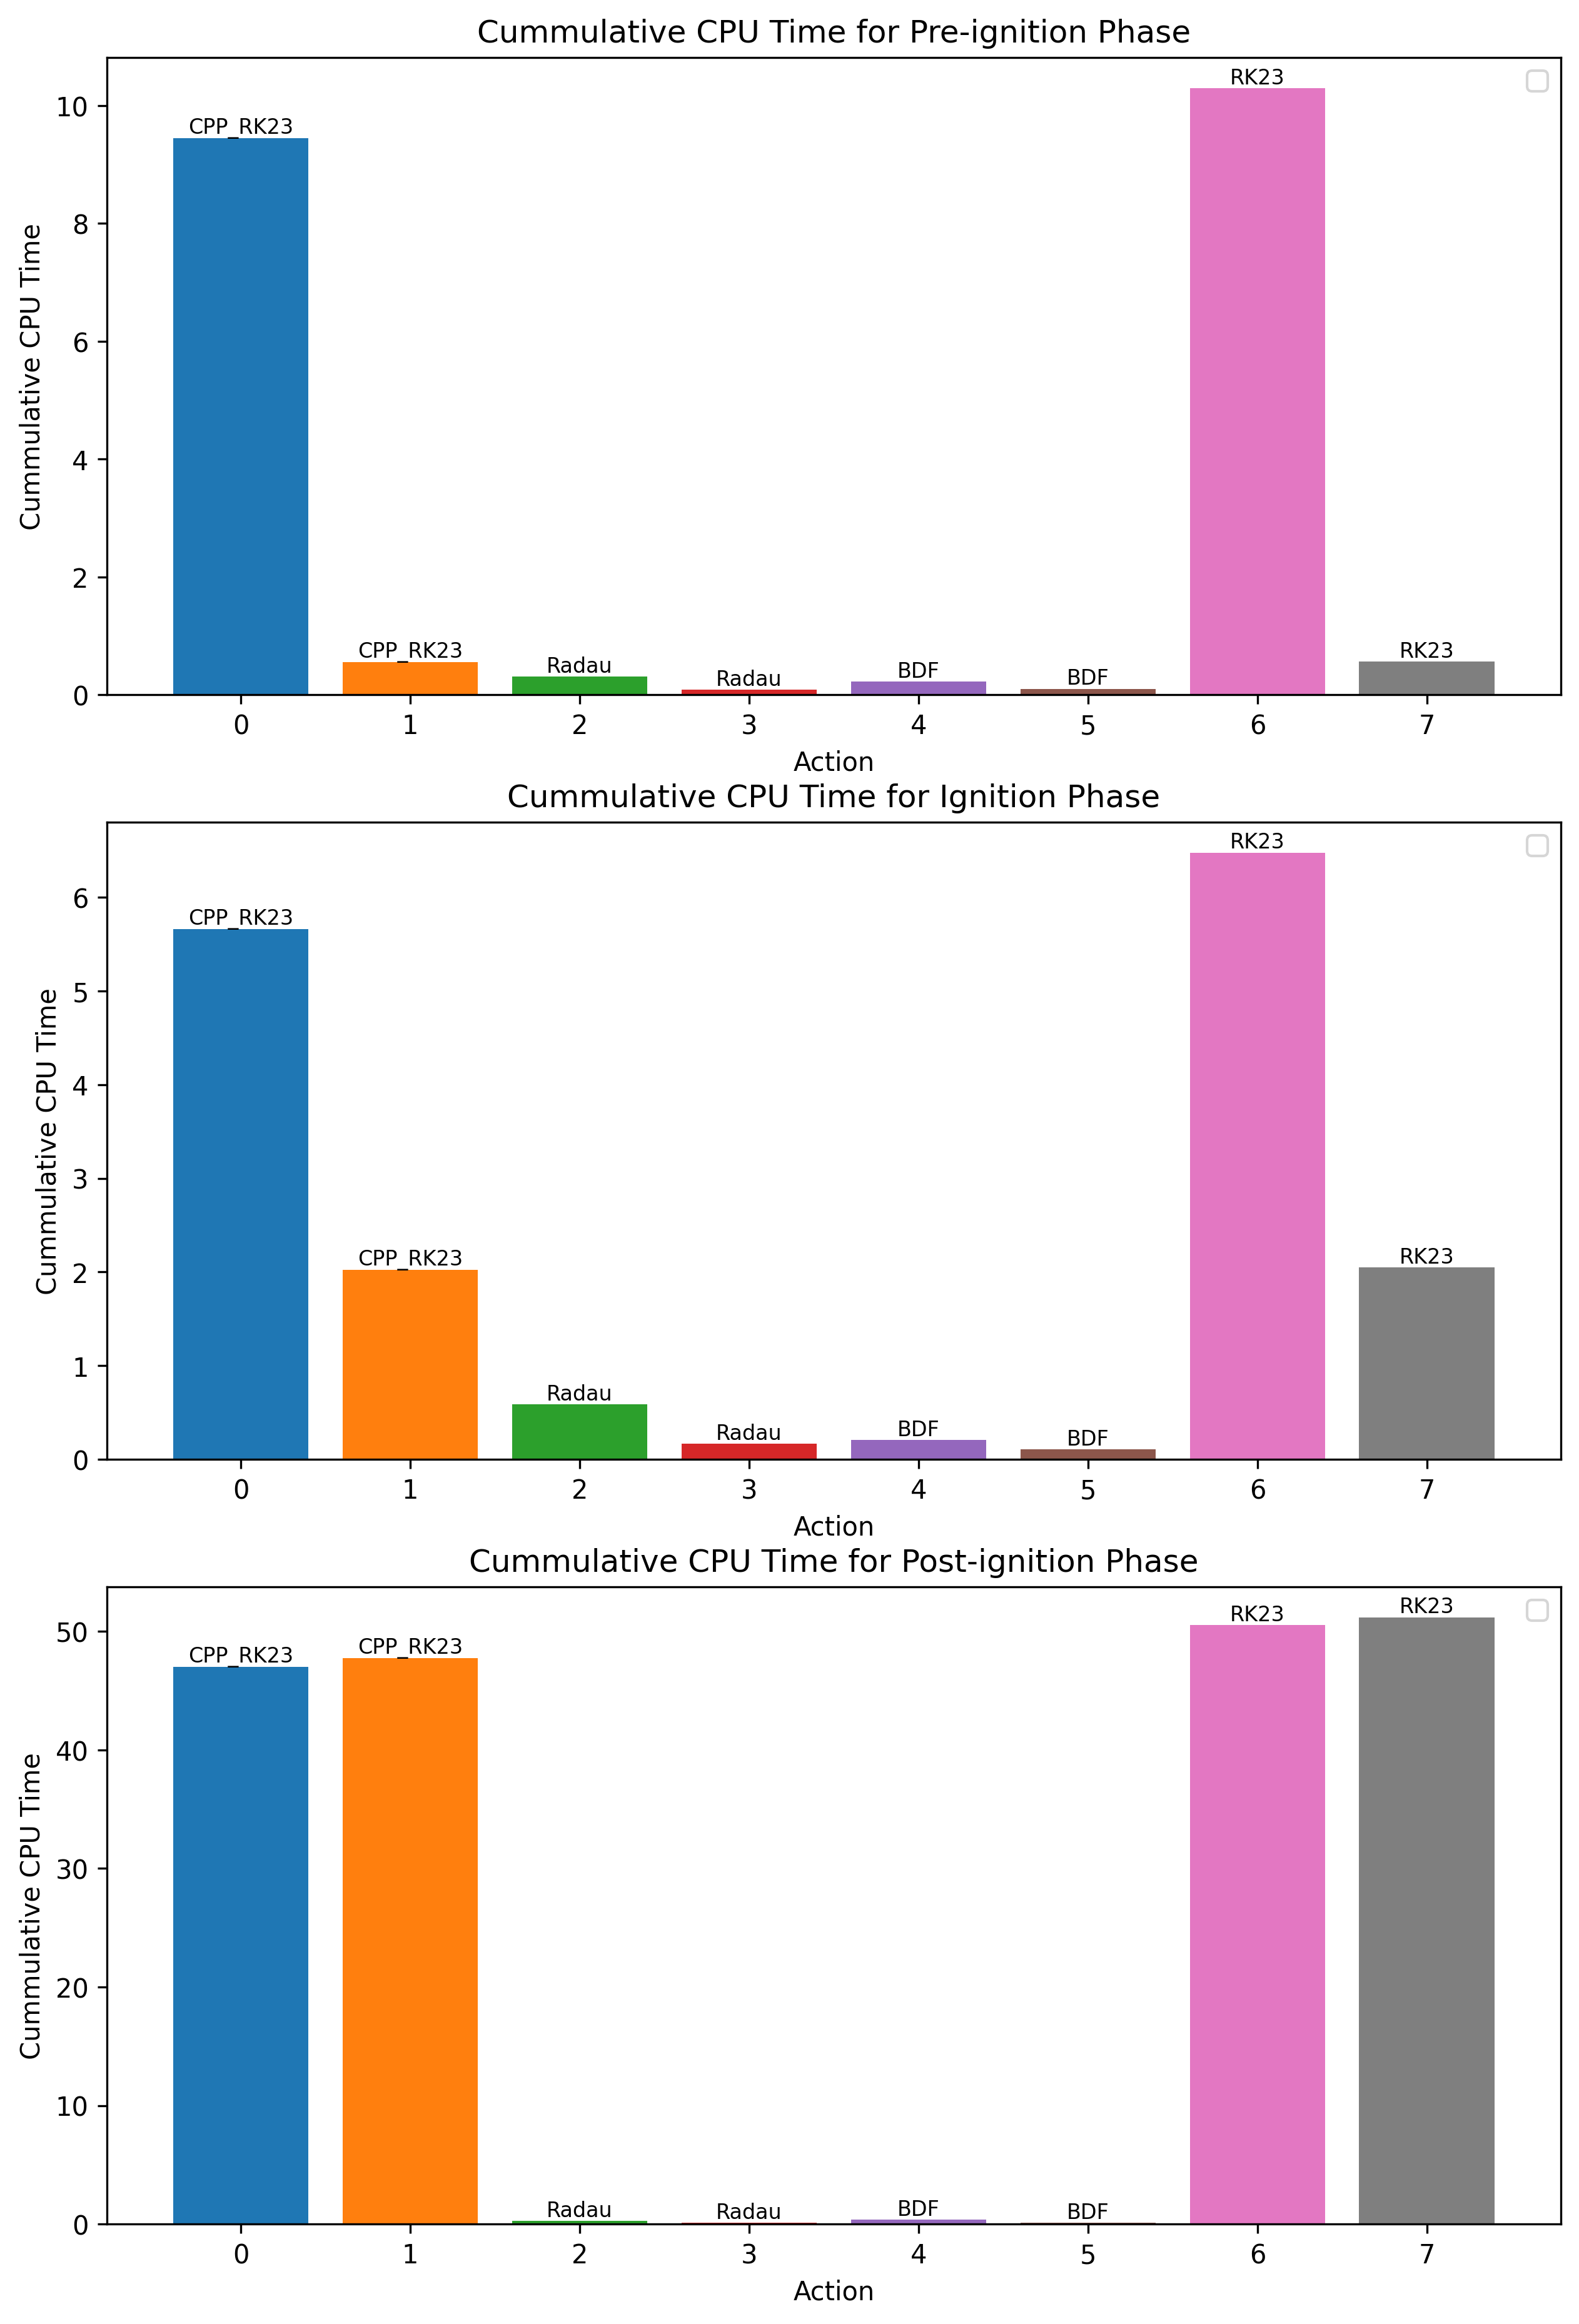

In [41]:
# get the cummulative cpu time for the pre-ignition phase, ignition phase and post-ignition phase
actions_pre_ignition_cpu_times_cum = {action: np.cumsum(actions_pre_ignition_cpu_times[action]) for action in range(len(env.action_list))}
actions_ignition_cpu_times_cum = {action: np.cumsum(actions_ignition_cpu_times[action]) for action in range(len(env.action_list))}
actions_post_ignition_cpu_times_cum = {action: np.cumsum(actions_post_ignition_cpu_times[action]) for action in range(len(env.action_list))}


# use a bar chart to plot the cummulative cpu times for the pre-ignition phase, ignition phase and post-ignition phase
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), dpi=300)
for action in range(len(env.action_list)):
    action_name = env.action_list[action]
    ax1.bar(action, actions_pre_ignition_cpu_times_cum[action])
    ax1.bar_label(ax1.containers[action], labels=[action_name[0]], fontsize=8)
    
ax1.legend()
ax1.set_xlabel('Action')
ax1.set_ylabel('Cummulative CPU Time')
ax1.set_title('Cummulative CPU Time for Pre-ignition Phase')

for action in range(len(env.action_list)):
    action_name = env.action_list[action]
    ax2.bar(action, actions_ignition_cpu_times_cum[action])
    ax2.bar_label(ax2.containers[action], labels=[action_name[0]], fontsize=8)
    
ax2.legend()
ax2.set_xlabel('Action')
ax2.set_ylabel('Cummulative CPU Time')
ax2.set_title('Cummulative CPU Time for Ignition Phase')

for action in range(len(env.action_list)):
    action_name = env.action_list[action]
    ax3.bar(action, actions_post_ignition_cpu_times_cum[action])
    ax3.bar_label(ax3.containers[action], labels=[action_name[0]], fontsize=8)
    
ax3.legend()
ax3.set_xlabel('Action')
ax3.set_ylabel('Cummulative CPU Time')
ax3.set_title('Cummulative CPU Time for Post-ignition Phase')
plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


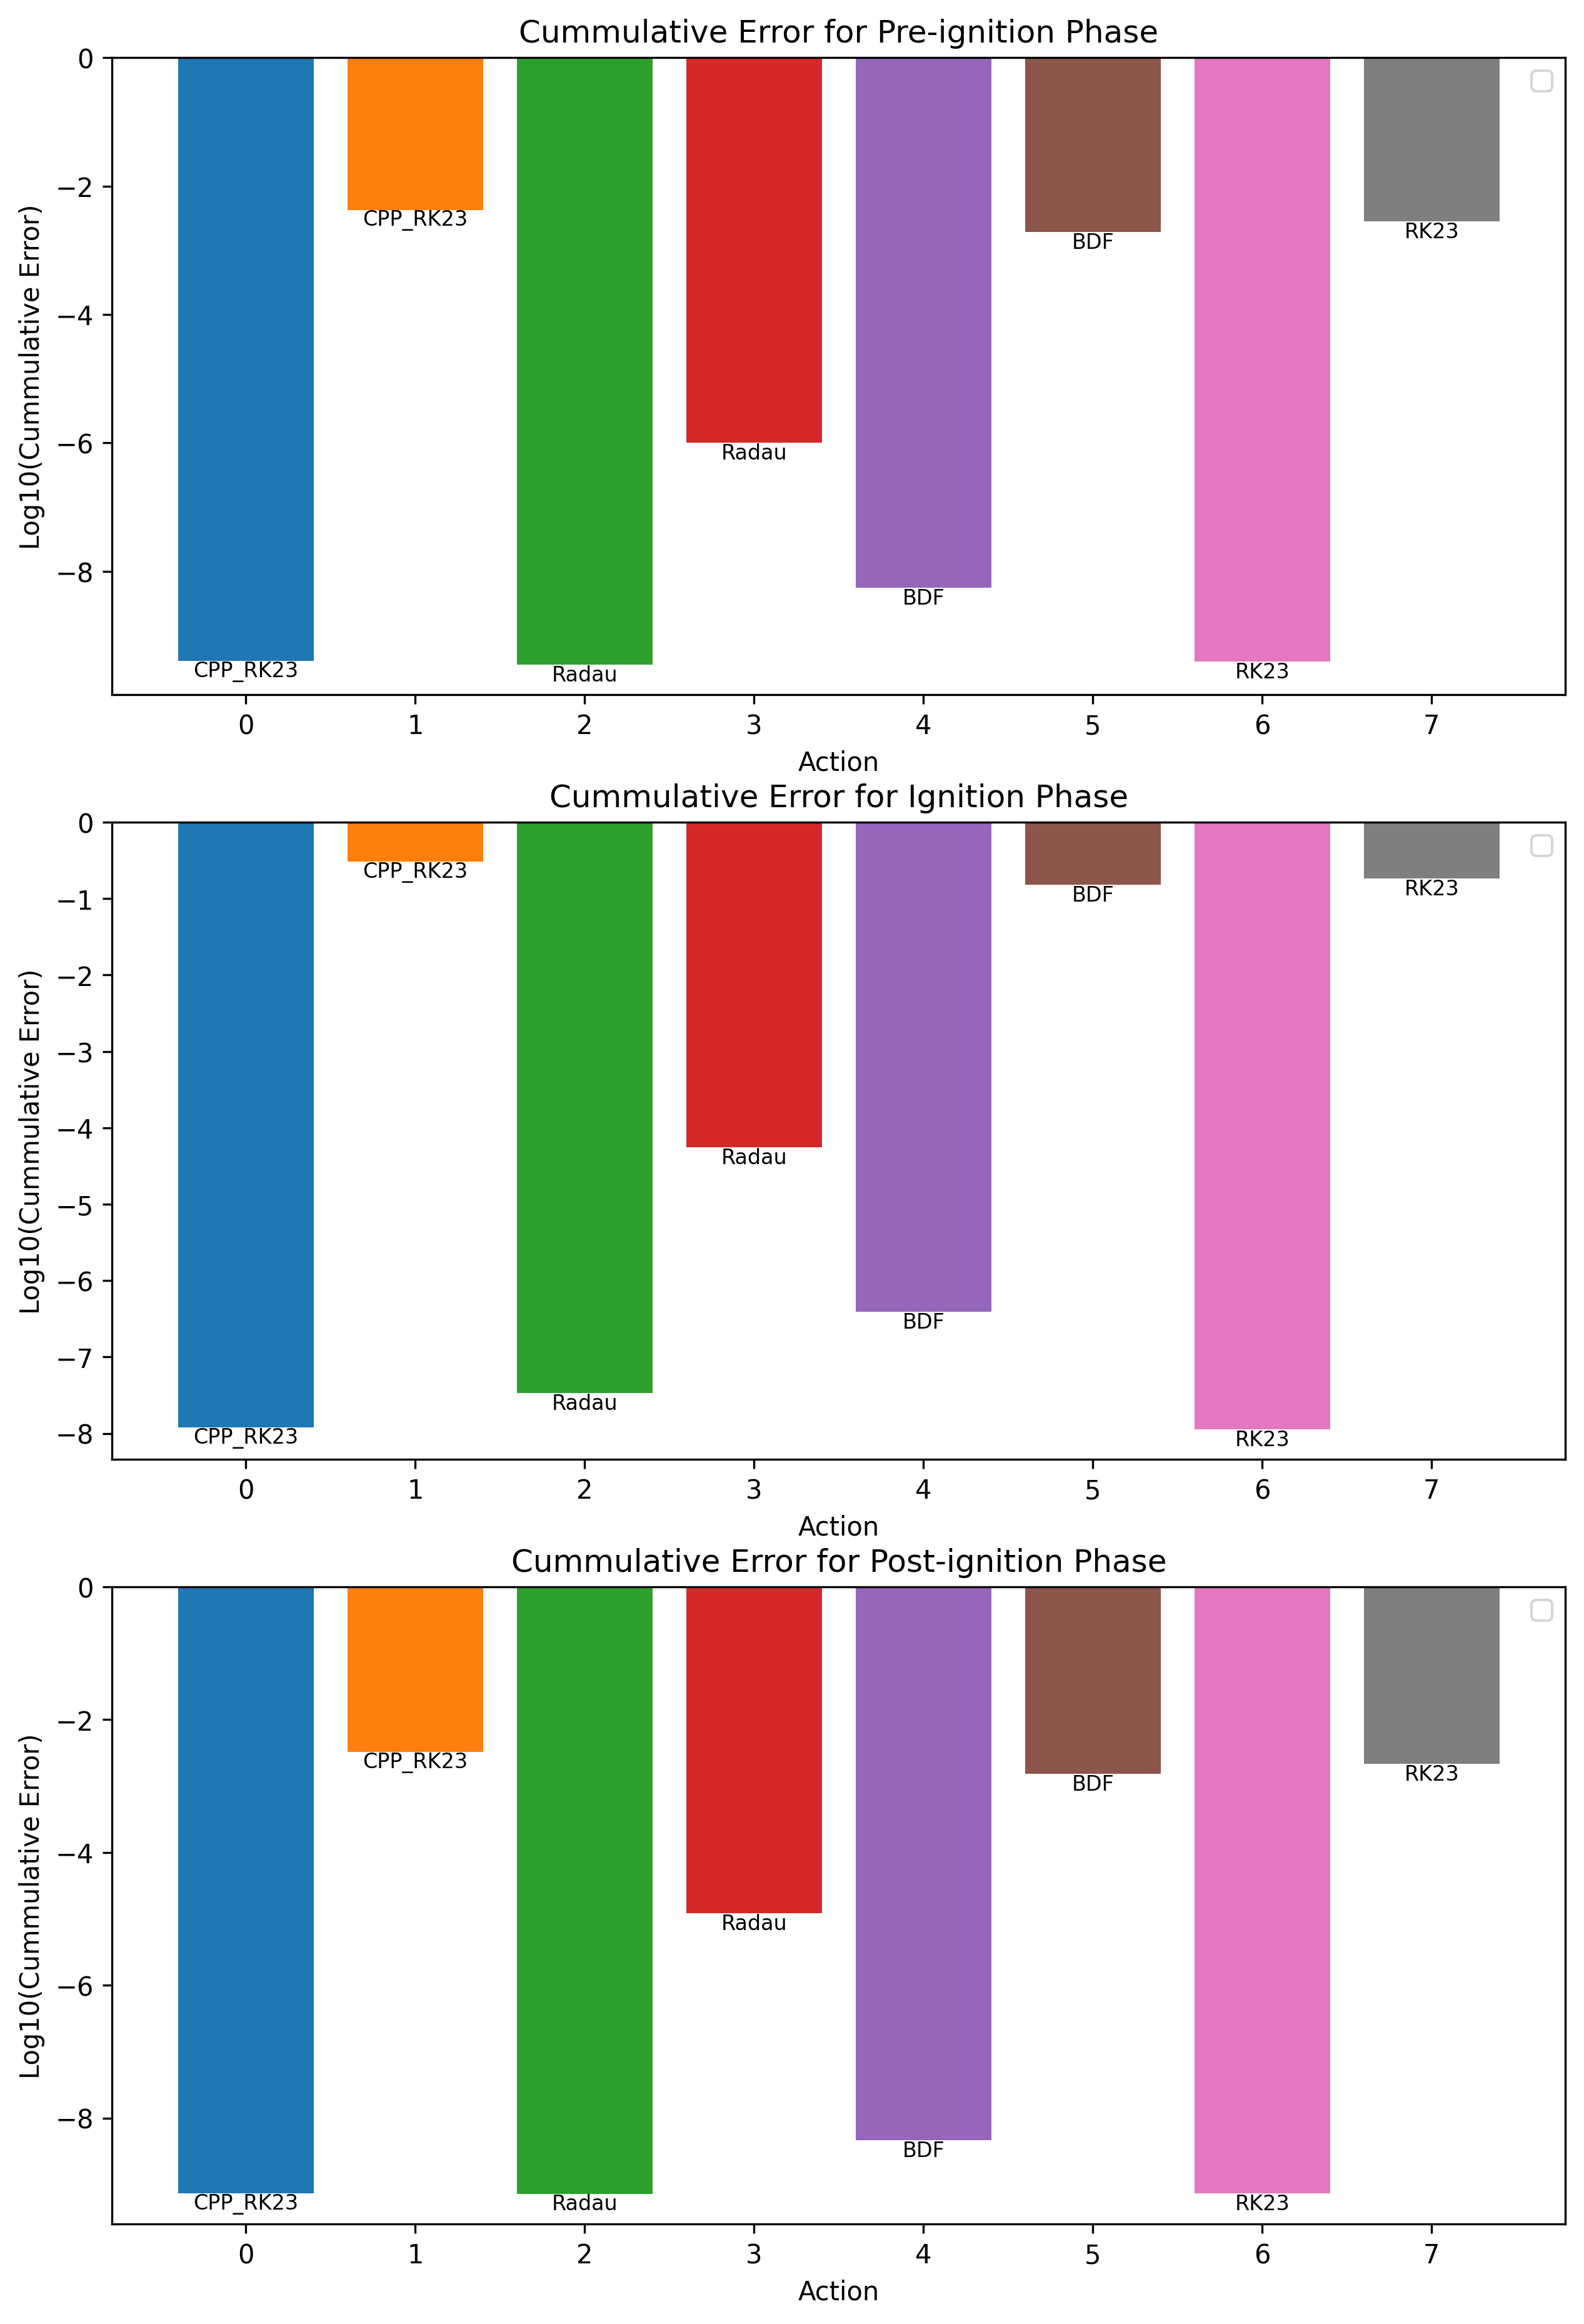

In [43]:
# get the cummulative error for the pre-ignition phase, ignition phase and post-ignition phase
actions_pre_ignition_errors_cum = {action: np.log10(np.cumsum(actions_pre_ignition_errors[action])) for action in range(len(env.action_list))}
actions_ignition_errors_cum = {action: np.log10(np.cumsum(actions_ignition_errors[action])) for action in range(len(env.action_list))}
actions_post_ignition_errors_cum = {action: np.log10(np.cumsum(actions_post_ignition_errors[action])) for action in range(len(env.action_list))}



# use a bar chart to plot the cummulative cpu times for the pre-ignition phase, ignition phase and post-ignition phase
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), dpi=300)
for action in range(len(env.action_list)):
    
    action_name = env.action_list[action]
    ax1.bar(action, actions_pre_ignition_errors_cum[action])
    ax1.bar_label(ax1.containers[action], labels=[action_name[0]], fontsize=8)
    
ax1.legend()
ax1.set_xlabel('Action')
ax1.set_ylabel('Log10(Cummulative Error)')
ax1.set_title('Cummulative Error for Pre-ignition Phase')

for action in range(len(env.action_list)):
    action_name = env.action_list[action]
    ax2.bar(action, actions_ignition_errors_cum[action])
    ax2.bar_label(ax2.containers[action], labels=[action_name[0]], fontsize=8)
    
ax2.legend()
ax2.set_xlabel('Action')
ax2.set_ylabel('Log10(Cummulative Error)')
ax2.set_title('Cummulative Error for Ignition Phase')

for action in range(len(env.action_list)):
    action_name = env.action_list[action]
    ax3.bar(action, actions_post_ignition_errors_cum[action])
    ax3.bar_label(ax3.containers[action], labels=[action_name[0]], fontsize=8)
    
ax3.legend()
ax3.set_xlabel('Action')
ax3.set_ylabel('Log10(Cummulative Error)')
ax3.set_title('Cummulative Error for Post-ignition Phase')
plt.show()



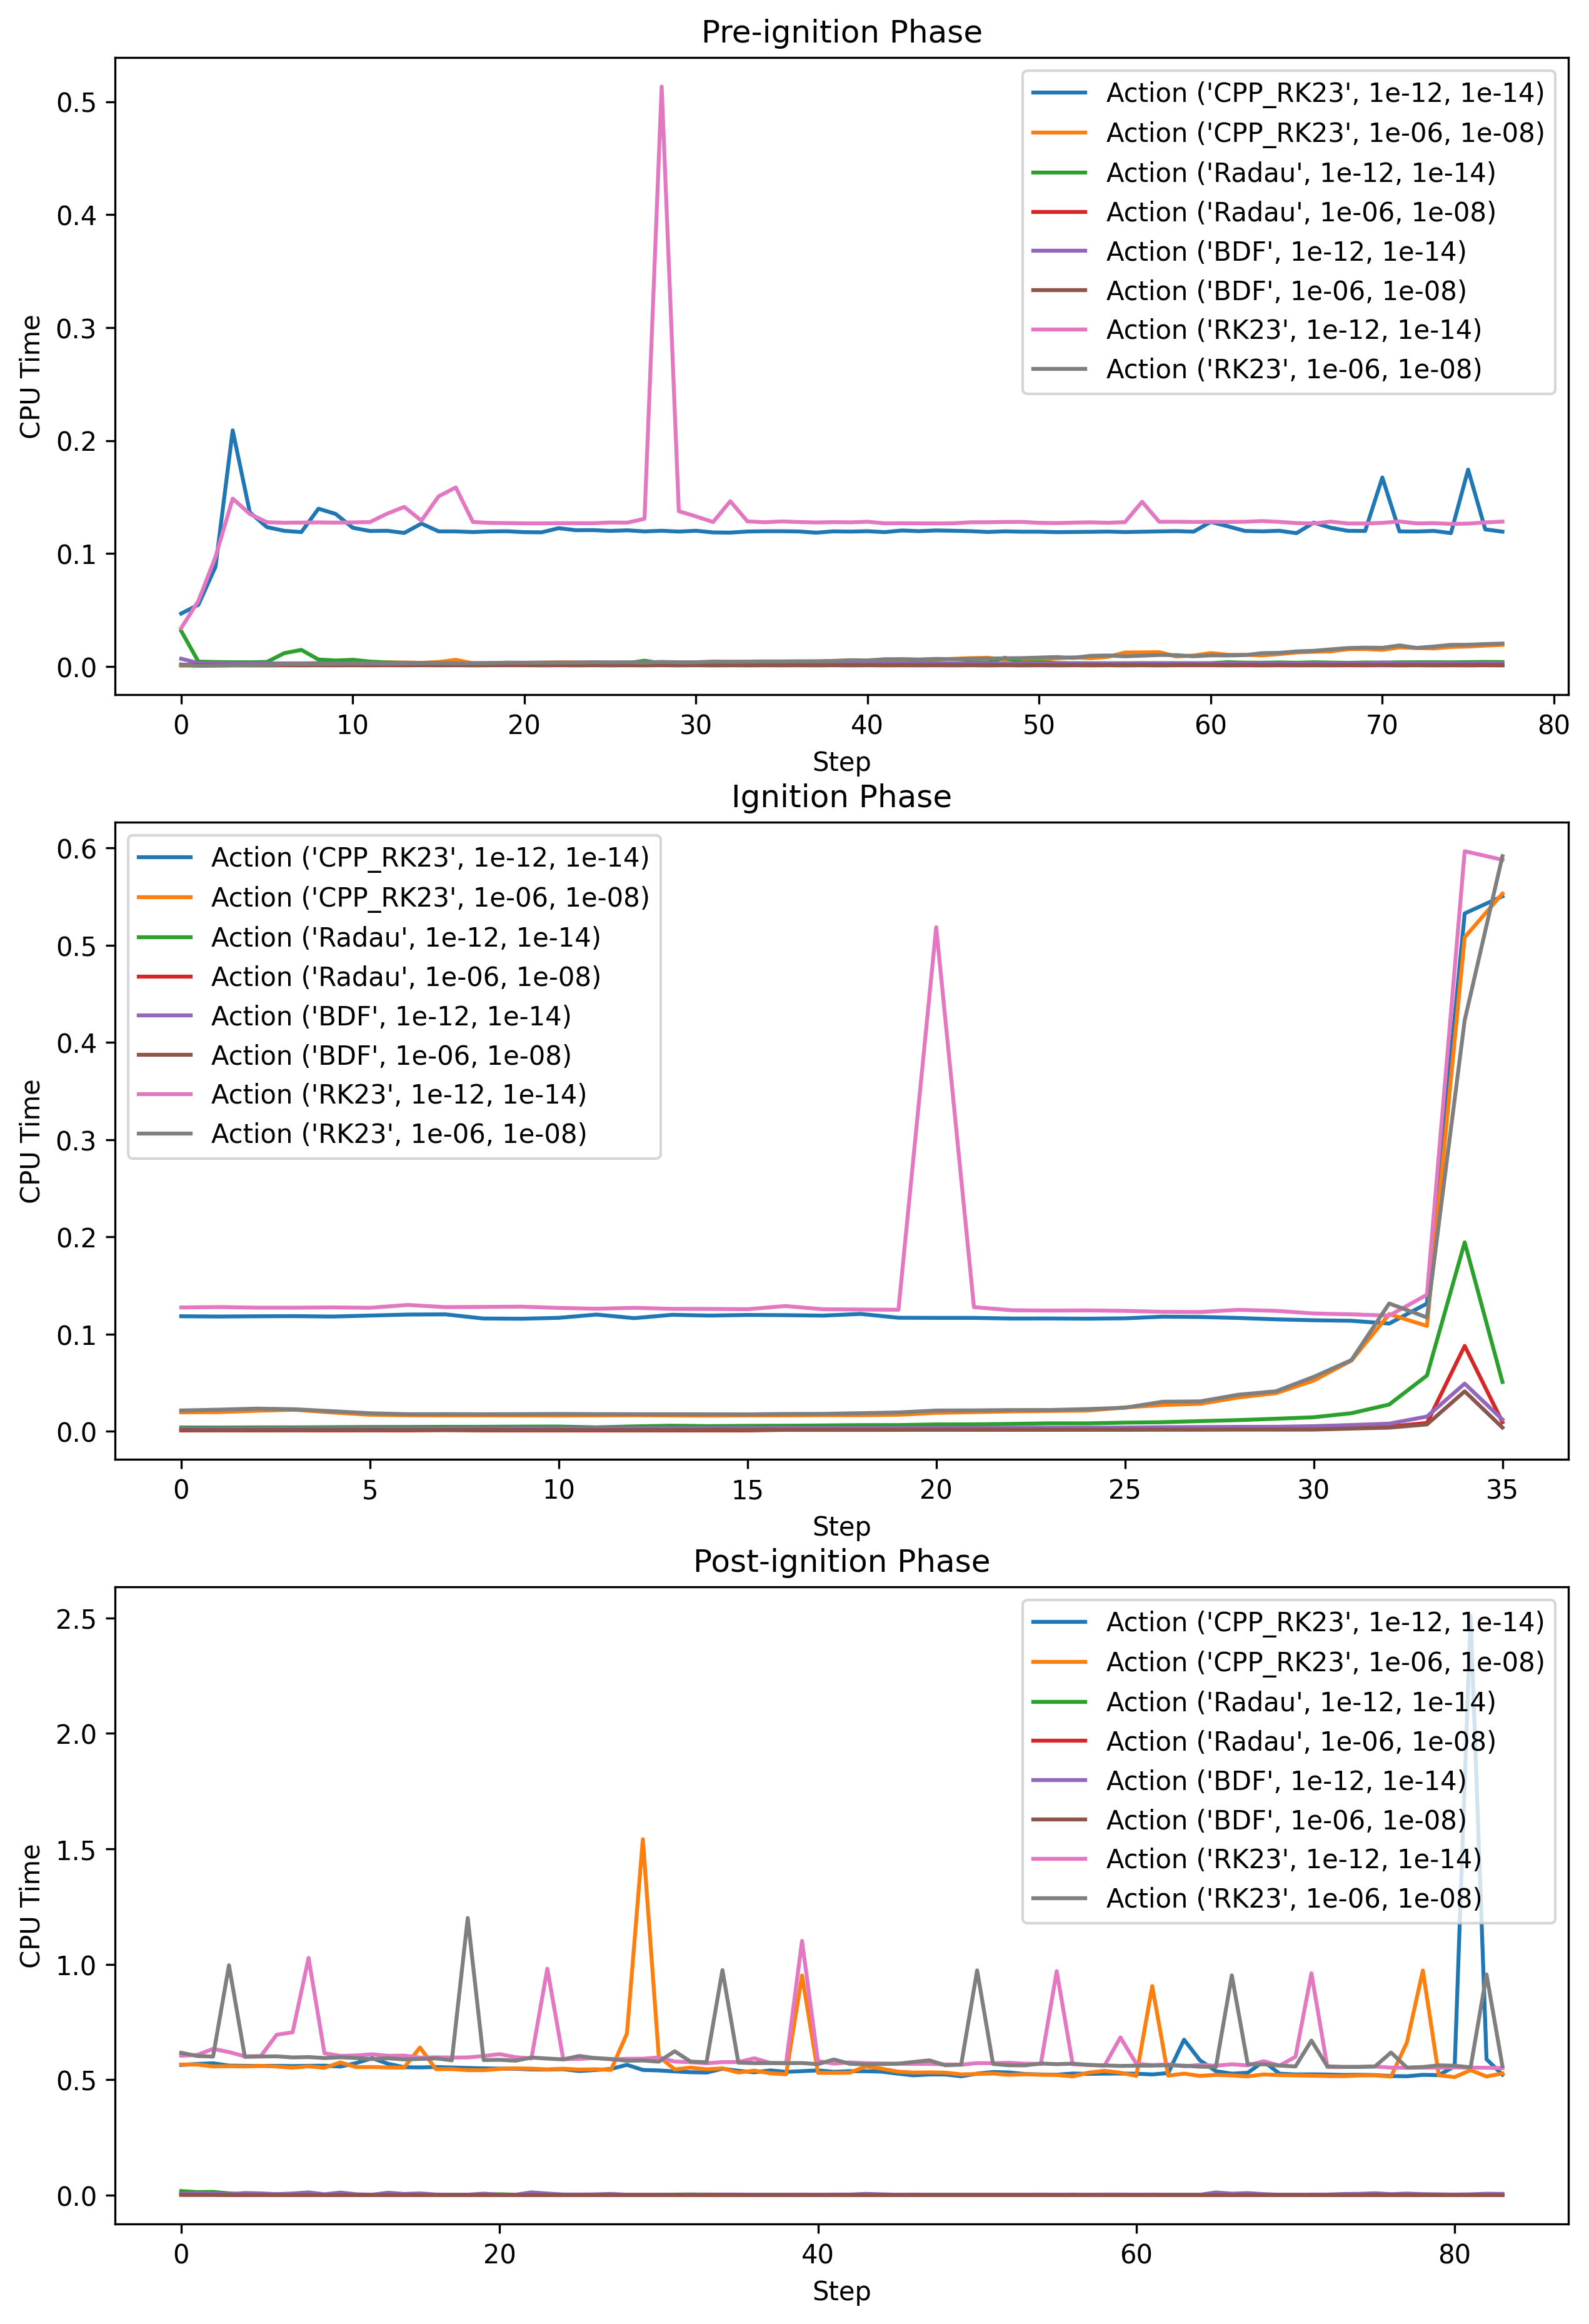

In [44]:
# plot the cpu times and errors for the ignition phase, pre-ignition phase and post-ignition phase

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), dpi=300)
for action in range(len(env.action_list)):
    ax1.plot(actions_cpu_times[action][:pre_ignition_phase], label=f'Action {env.action_list[action]}')
ax1.set_xlabel('Step')
ax1.set_ylabel('CPU Time')
ax1.set_title('Pre-ignition Phase')
ax1.legend()
for action in range(len(env.action_list)):
    ax2.plot(actions_cpu_times[action][ignition_phase[0]:ignition_phase[-1]], label=f'Action {env.action_list[action]}')
ax2.set_xlabel('Step')
ax2.set_ylabel('CPU Time')
ax2.set_title('Ignition Phase')
ax2.legend()
for action in range(len(env.action_list)):
    ax3.plot(actions_cpu_times[action][post_ignition_phase:], label=f'Action {env.action_list[action]}')
ax3.set_xlabel('Step')
ax3.set_ylabel('CPU Time')
ax3.set_title('Post-ignition Phase')
ax3.legend()
plt.show()



In [ ]:
actions_cpu_times[0][ignition_phase[0]:ignition_phase[-1]]


In [203]:
print(f"Pre-ignition phase: {pre_ignition_phase} - Ignition phase: {ignition_phase} - Post-ignition phase: {post_ignition_phase}")

Pre-ignition phase: 78 - Ignition phase: [ 79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116] - Post-ignition phase: [117]


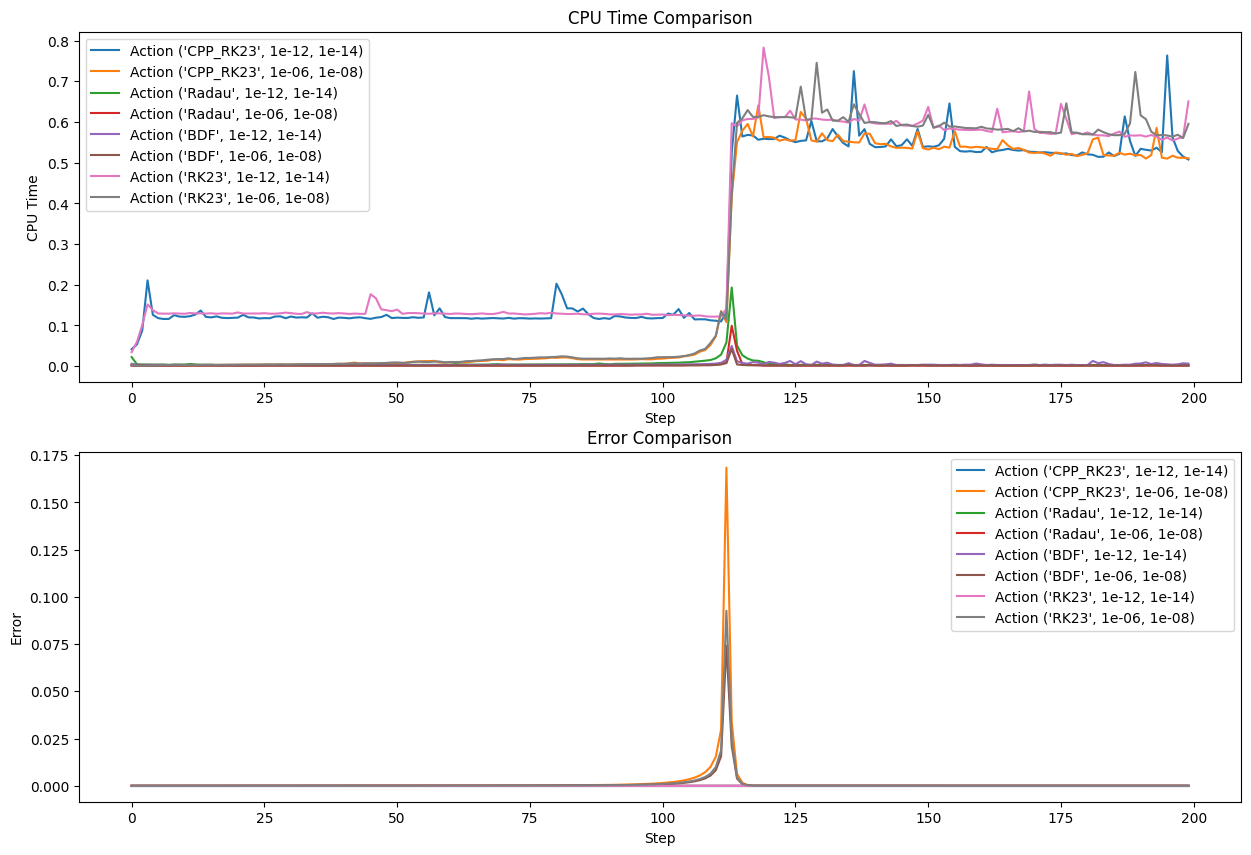

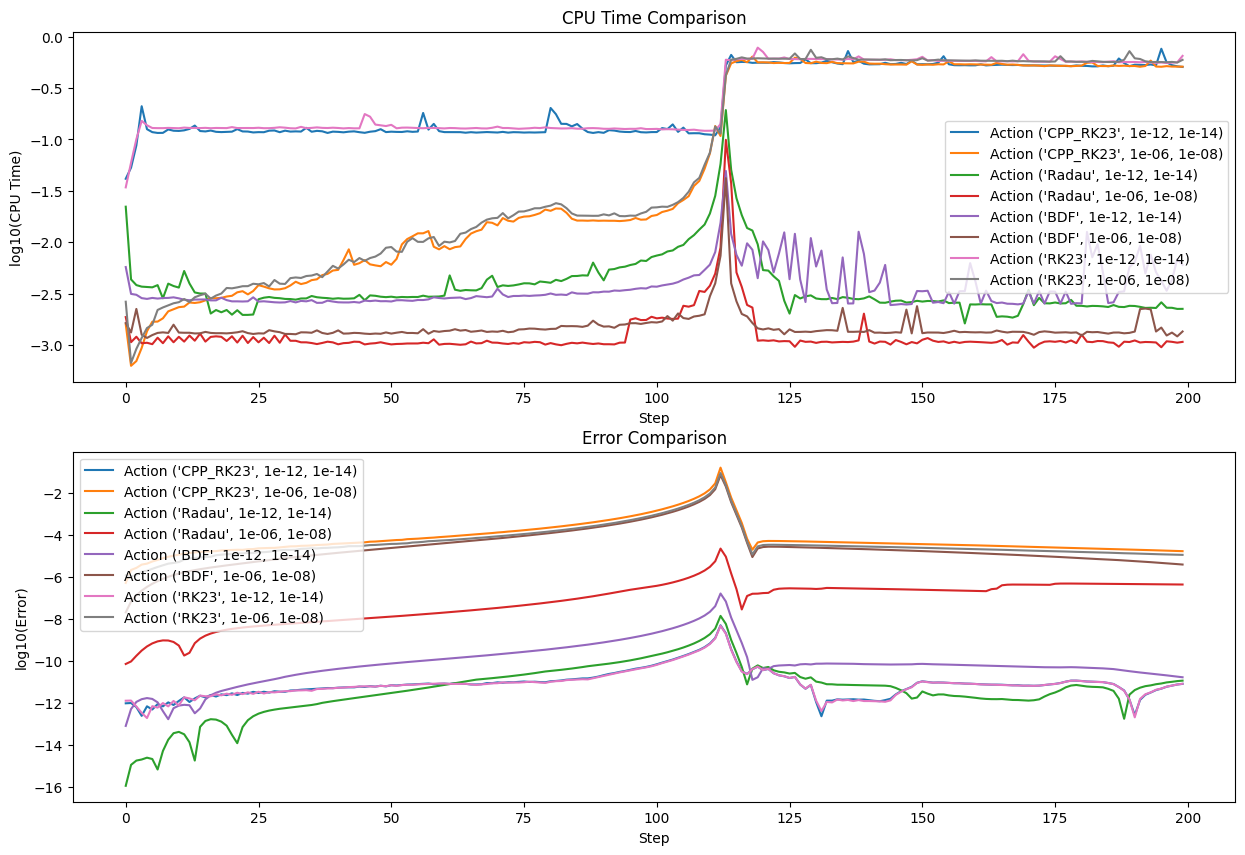

In [176]:
# create plots for each action
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
for action in range(len(env.action_list)):
    ax1.plot(actions_cpu_times[action], label=f'Action {env.action_list[action]}')
    ax2.plot(actions_errors[action], label=f'Action {env.action_list[action]}')
ax1.legend()
ax1.set_xlabel('Step')
ax1.set_ylabel('CPU Time')
ax1.set_title('CPU Time Comparison')
ax2.legend()
ax2.set_xlabel('Step')
ax2.set_ylabel('Error')
ax2.set_title('Error Comparison')
plt.show()


# plot the log of the cpu times and errors
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
for action in range(len(env.action_list)):
    ax1.plot(np.log10(actions_cpu_times[action]), label=f'Action {env.action_list[action]}')
    ax2.plot(np.log10(actions_errors[action]), label=f'Action {env.action_list[action]}')
ax1.legend()
ax1.set_xlabel('Step')
ax1.set_ylabel('log10(CPU Time)')
ax1.set_title('CPU Time Comparison')
ax2.legend()
ax2.set_xlabel('Step')
ax2.set_ylabel('log10(Error)')
ax2.set_title('Error Comparison')
plt.show()

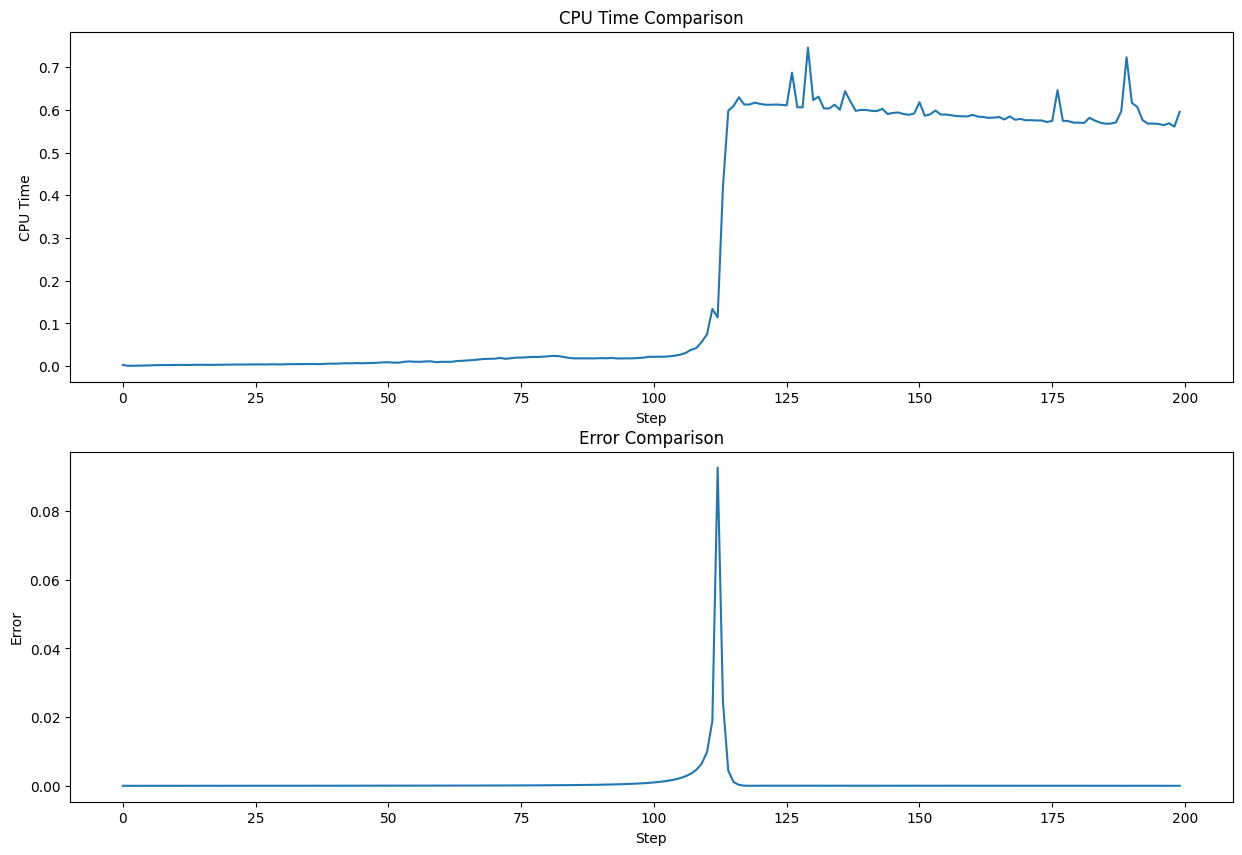

In [177]:
# plot the cpu times
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10)   )
ax1.plot(env.cpu_times)
ax1.set_xlabel('Step')
ax1.set_ylabel('CPU Time')
ax1.set_title('CPU Time Comparison')
ax2.plot(env.errors)
ax2.set_xlabel('Step')
ax2.set_ylabel('Error')
ax2.set_title('Error Comparison')
plt.savefig('kcpu_times_errors.png')
plt.show()


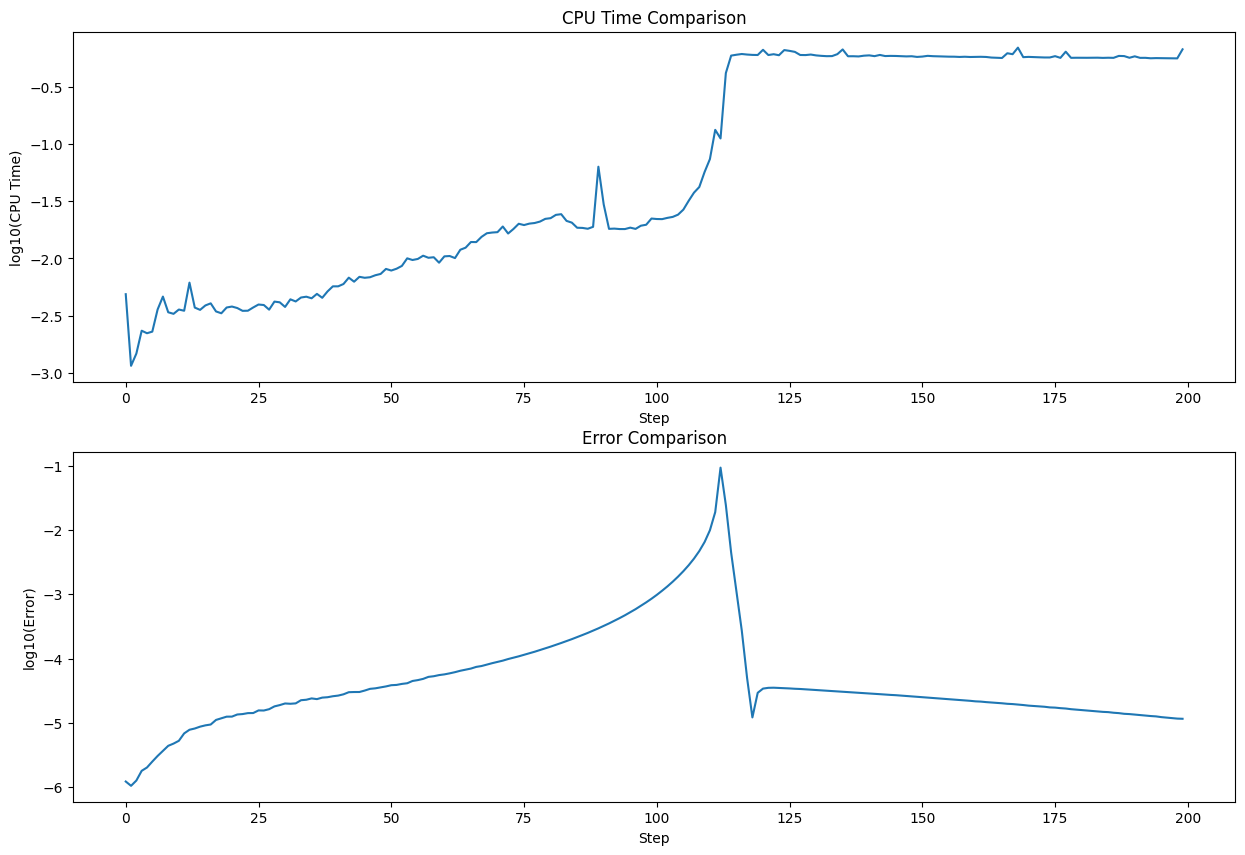

In [165]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10)   )
ax1.plot(np.log10(env.cpu_times))
ax1.set_xlabel('Step')
ax1.set_ylabel('log10(CPU Time)')
ax1.set_title('CPU Time Comparison')
ax2.plot(np.log10(env.errors))
ax2.set_xlabel('Step')
ax2.set_ylabel('log10(Error)')
ax2.set_title('Error Comparison')
plt.savefig('kcpu_times_errors_log.png')
plt.show()